In [2]:
import numpy as np
from icecream import ic
from tqdm import tqdm
import cProfile 
import time
import warnings
import math



In [2]:
# Warning settings
np.seterr(all="ignore") #ignore np warnings, the output will be nan or inf and will be handled correctly in the code. (using np.errstate slows down the code)
# warnings.filterwarnings("ignore", category=RuntimeWarning)

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

### Load a problem

In [3]:
# Configuration
TRAIN_TEST_RATIO=0.4
PROBLEM_NUMBER=8

# Load problem data with context manager protocol
with np.load(f'data/problem_{PROBLEM_NUMBER}.npz') as problem:
    x_1 = problem['x']
    y_1 = problem['y']

# Shuffle the data
permutation = np.random.permutation(len(y_1))
x_1 = x_1[:, permutation]
y_1 = y_1[permutation]

# Determine train test split sizes
problem_len=len(y_1)
train_size=int(TRAIN_TEST_RATIO*problem_len)

# Split data
x_train=x_1[:, :train_size]
y_train=y_1[:train_size]

x_test=x_1[:, train_size:]
y_test=y_1[train_size:]

# To view the npz file, run python -m npzviewer 
# Print dataset information
print(f"Problem number: {PROBLEM_NUMBER}, variables: {x_1.shape[0]}, train size: {train_size}, test size: {problem_len-train_size}")


Problem number: 8, variables: 6, train size: 20000, test size: 30000


### Numpy functions definition

In [4]:
unary_ops = [
    np.negative,
    np.abs,
    np.sqrt,
    np.exp,
    np.log,
    np.sin,
    np.cos,
    np.tan,
    np.arcsin,
    np.arccos,
    np.arctan,
    np.square
    # np.ceil,
    # np.floor
]

binary_ops = [
    np.add,
    np.subtract,
    np.multiply,
    np.divide,
    np.power,
    # np.maximum,
    # np.minimum,
    np.mod
]

### Symbolic regression class

In [5]:
from tree import Tree

class SymbolicRegression:
    def __init__(self, population_size, max_generations, mutation_rate, elitism_size, grow_full_ratio,random_parents_min_ratio,random_parents_max_ratio):
        self.population_size = population_size
        self.max_generations = max_generations
        self.mutation_rate = mutation_rate
        self.elitism_size = elitism_size
        self.grow_full_ratio = grow_full_ratio

        self.unary_ops = unary_ops
        self.binary_ops = binary_ops
        self.best_fitness_history = []
        # self.random_parents_generations = self.max_generations * 0.005   # random parents selection generations
  
        self.random_parents_min_ratio=random_parents_min_ratio
        self.random_parents_max_ratio=random_parents_max_ratio
        self.random_parents_ratio=self.random_parents_min_ratio

        self.population = np.array([
            Tree("grow") if i < int(population_size * self.grow_full_ratio) else Tree("full")
            for i in range(population_size)
        ])

    # Parents selection methods
    def select_parents_fitness_age(self, n_elems=2):
        """
        Evolves a population considering how long the genotype has been in the population and fitness.
        Reference: Age-fitness pareto optimization https://dl.acm.org/doi/10.1145/1830483.1830584
        """
        return sorted(self.population, key=lambda tree: (-tree.fitness, -tree.age))[:n_elems]

    def select_parents_fitness_proportional(self, n_elems=2, epsilon=1e-10):
        """
        Individuals with lower fitness have an higher probability to be selected.
        Premature convergence if few individuals have significantly better fitness than others.
        """
        fitnesses = [tree.fitness for tree in self.population]
        inverted_fitnesses = [1 / (fitness + epsilon) for fitness in fitnesses]  # avoid division by zero
        probabilities = inverted_fitnesses / sum(inverted_fitnesses)
        parent1, parent2 = np.random.choice(self.population, size=n_elems, p=probabilities, replace=False)
        return parent1, parent2
    
    def select_parents_lexicase(self):  # TODO: implement this
        pass

    def select_parents_rank_based(self, n_elems=2):
        """
        Rank-based selection method.
        Assigns probabilities based on inversed ranks instead of absolute fitness values.
        """
        fitnesses = np.array([tree.fitness for tree in self.population])
        ranks = np.argsort(fitnesses)
        inversed_ranks = len(fitnesses) - ranks
        probabilities = inversed_ranks / np.sum(inversed_ranks)
        return np.random.choice(self.population, n_elems, p=probabilities,replace=False)
    
    def select_parents_tournament(self):
        tournament_size = 7
        tournament = list(np.random.choice(self.population, tournament_size,replace=False))
        tournament.sort(key=lambda x: x.fitness)
        return tournament[0], tournament[1]
    
    def select_parents(self):
        # if np.random.rand() < 0:
            # return self.select_parents_tournament()
        # else:
        return self.select_parents_fitness_proportional()

    # Mutation
    def mutate(self, tree):
        # if np.random.rand() < self.mutation_rate:
            if np.random.rand() < 0.5:
                tree.mutate_subtree()
            else:
                #pick a random number between 1 and 5
                mutation_n=np.random.randint(1,6)
                tree.mutate_single_node(num_mutations=mutation_n)

    def offspring_generation(self, current_generation):
        new_population = np.array([])

        # Elitism   
        # elite_individuals = self.population[:self.elitism_size]
        # elite_individuals=np.unique(elite_individuals)

        offsprings=np.array([])
        # Main loop
        while len(offsprings) < self.population_size//2: # //2:
            # encourage exploration in initial generations
            if np.random.random() < self.random_parents_ratio:
                parent1, parent2 = np.random.choice(self.population, size=2, replace=False)
            else:
                parent1, parent2 = self.select_parents()
            # generate offsprings
         
            if(np.random.rand() < self.mutation_rate):
                parent_clone=parent1.copy_tree()
                self.mutate(parent_clone)
                Tree.collapse_branch(parent_clone.root)
                parent_clone.compute_fitness()
                # if(parent_clone not in new_population):
                offsprings = np.append(offsprings, [parent_clone])

            else:    
                offspring1,offspring2=Tree.crossover(parent1, parent2)
                if(offspring1 is not None or offspring2 is not None):
                    Tree.collapse_branch(offspring1.root)
                    Tree.collapse_branch(offspring2.root)
                
                    # self.mutate(offspring1)
                    # self.mutate(offspring2)

                    #Trying stuff
                    # offspring1.compute_fitness()
                    # offspring2.compute_fitness()
                    # tmp_fitnesses=[tree.fitness for tree in new_population]
                    # if offspring1.fitness not in tmp_fitnesses:
                    #     offsprings.append(offspring1)
                    # if offspring2.fitness not in tmp_fitnesses:
                    #     offsprings.append(offspring2)
                    
                    offspring1.compute_fitness()
                    offspring2.compute_fitness()
                    #if osspring1 is not alredy in population, already defined the eq as the fitness comparison
                    # if offspring1 not in new_population:
                    #     offsprings = np.append(offsprings, [offspring1])
                    # if offspring2 not in new_population:
                    #     offsprings = np.append(offsprings, [offspring2])
                    

                    offsprings = np.append(offsprings, [offspring1, offspring2])

            # new_population=np.concatenate((new_population,offsprings))
                
        return offsprings

       
    def evolve(self, verbose=True):
        best_tree = None
        best_fitness = np.inf
        take_over = False
        bad_increment=0
        checkpoint=np.array([])
        best_fitness_true=np.inf
        # self.population.sort(key=lambda x: x.fitness) 
        #numpy sort of population over fitness
        self.population.sort()
        # print(f"Initial best fitness: {self.population[0].fitness}")
        # print(f"Initial best fitness: {self.population[1].fitness}")
        # print(f"Initial best fitness: {self.population[2].fitness}")
        # print(f"Initial worst fitness: {self.population[-1].fitness}")



        for generation in tqdm(range(self.max_generations)):
            
            if take_over:
                print(f"Takeover at {generation} gen")
                #trasform the population in set and then back to list to remove duplicates
                self.population=np.unique(self.population)
                #sort the population based on fitness
                # self.population.sort()
                # self.population = self.population[:int(self.population_size*0.1)]
                #count self.population size
                remaining_trees=len(self.population)
                # print(f"Takeover at {generation} gen, remaining trees: {remaining_trees}")
                new_trees = np.array([Tree("grow") for _ in range(int(self.population_size-remaining_trees))])
                self.population=np.concatenate((self.population,new_trees))
                
            
            
            

            # for tree in new_population:
            #     tree.compute_fitness()
            new_population = self.offspring_generation(current_generation=generation)
            
            self.population=np.concatenate((self.population,new_population))
            
            # generation_fitnesses = [tree.fitness for tree in self.population]
            # generation_best_fitness = min(generation_fitnesses)

  
            
            #trim the population to the best population_size
            self.population.sort()
            self.population = self.population[:self.population_size]
            # print(f"Generation {generation + 1}, Best Fitness: {best_fitness}")



            
            if(best_fitness-self.population[0].fitness > 10000):
                # checkpoint=self.population
                # print(f"Reset bad_increment at {generation} gen")
                bad_increment=0
                if self.random_parents_ratio>self.random_parents_min_ratio:
                    self.random_parents_ratio=self.random_parents_min_ratio
                else:
                    bad_increment+=1
                    if self.random_parents_ratio<self.random_parents_max_ratio:
                        self.random_parents_ratio+=0.05


            if self.population[0].fitness < best_fitness:
                best_tree = self.population[0]
                best_fitness = best_tree.fitness
                self.best_fitness_history.append(best_fitness)
                if(best_fitness<best_fitness_true):
                    best_fitness_true=best_fitness
            
            


        
                
           


            take_over = False
            if bad_increment>50:
                print(f"----- New population at {generation} gen")
            #     #concatenate the checkpoint to the population
            #     # self.population=np.concatenate((self.population,checkpoint))
            #     # regressor2=SymbolicRegression(100, 100, 0.5, 10, 1)
            #     # best_tree_tmp, _=regressor2.evolve(verbose=False)
            #     # print(f"Best fitness of the checkpoint: {best_tree_tmp.fitness}")
            #     # self.population=np.concatenate((self.population,[best_tree_tmp]))
            #     # take_over=True
                bad_increment=0
                self.population=np.array([Tree("grow") for _ in range(self.population_size)])
                self.population.sort()
                self.random_parents_ratio=self.random_parents_min_ratio
                
                

                
            

            n_best = [elem for elem in self.population if elem.fitness == self.population[0].fitness]
            
            if len(n_best) > 0.9 * self.population_size:
                    take_over = True
                    # print(f"Takeover at {generation} gen")   

            if(generation%50==0 and verbose):
                print(f"Generation {generation + 1}, Best Fitness: {best_fitness}, Best fitness true:{best_fitness_true} Rand ratio: {self.random_parents_ratio} Best Formula: {best_tree.to_np_formula()}")
            if best_fitness <= 1e-33:
                break   
        return best_tree, best_fitness


In [6]:
#Problem definition
POPULATION_SIZE = 100
MAX_GENERATIONS = 100000
MUTATION_RATE = 0.35
ELITISM_SIZE = 2
GROW_FULL_RATIO = 1
#TREE_DEPTH = math.ceil(math.log(x_train.shape[0],2))+1 #FIXME: temporary solution,IDK if it's good. (it's the depth to contain all the variables+1)
#print("Tree depth:",TREE_DEPTH)
TREE_DEPTH = 10
VAR_NUM = x_train.shape[0]
CONST_RANGE=20 # Constats will be in the range [-CONST_RANGE, CONST_RANGE]
RANDOM_PARENTS_MIN_RATIO=0.1
RANDOM_PARENTS_MAX_RATIO=0.5


Tree.set_params(unary_ops, binary_ops, VAR_NUM, CONST_RANGE,TREE_DEPTH, x_train, y_train, x_test, y_test)
regressor = SymbolicRegression(
    POPULATION_SIZE,
    MAX_GENERATIONS,
    MUTATION_RATE,
    ELITISM_SIZE,
    GROW_FULL_RATIO,
    RANDOM_PARENTS_MIN_RATIO,
    RANDOM_PARENTS_MAX_RATIO

    #(x_train, y_train)   # per lexicase
)

In [7]:
#UNCOMMENT TO PROFILE THE CODE (and comment the rest of the code)
# cProfile.run("regressor.evolve()",sort="tottime") #for profiling so we can see the time taken by each function
#the output will include the following columns:
#tottime: Total time spent in the function (excluding time spent in other functions it calls).
#cumtime: Cumulative time spent in the function (including time spent in sub-functions).


# Execute the algorithm
best_tree, best_fitness = regressor.evolve()

# Print the formula
print("Best Formula:\n")
print(best_tree.to_np_formula())

# Print the fitness
print(f"Train Fitness: {best_fitness}")
best_tree.compute_fitness(test="test")
print(f"Test Fitness: {best_tree.fitness}")
print(f"Train-Test Discrepancy: {best_fitness-best_tree.fitness}")
best_tree.compute_fitness(test="all")
print(f"All Fitness: {best_tree.fitness}")

# Print the best tree
print(f"Best Fitness History: {regressor.best_fitness_history}, changed {len(regressor.best_fitness_history)} times")
print("Best Tree:")
best_tree.add_drawing()

  0%|          | 2/100000 [00:00<3:44:31,  7.42it/s]

Generation 1, Best Fitness: 22736468.304518152, Best fitness true:22736468.304518152 Rand ratio: 0.15000000000000002 Best Formula: np.remainder(np.negative(np.subtract(np.add(np.subtract(np.divide(18.025114417957973, -10.634050463695178), np.add(-16.787353471103938, x[5])), np.subtract(np.subtract(-0.5326050708671382, -15.713612067239794), np.divide(x[5], -12.5818687663944))), np.divide(np.divide(np.power(8.436781132251166, -7.2053057177586375), np.divide(3.2600204969935795, -13.986695980866601)), np.remainder(np.multiply(x[5], -1.2777392903188343), np.multiply(x[0], x[1]))))), np.multiply(np.remainder(np.remainder(np.subtract(np.multiply(x[1], -13.591521470829555), np.subtract(-6.977060995867506, x[2])), np.divide(np.add(x[4], 14.661829023200148), np.add(x[2], 16.76192191797496))), np.subtract(np.add(np.subtract(x[2], 4.217651083605109), np.add(14.172947189714542, x[5])), np.power(13.863455447366313, np.add(12.44625841049156, x[3])))), np.divide(np.sqrt(np.exp(np.multiply(x[1], 1.4533

  0%|          | 52/100000 [00:08<4:40:44,  5.93it/s]

Generation 51, Best Fitness: 21394751.53930623, Best fitness true:21394751.53930623 Rand ratio: 0.1 Best Formula: np.remainder(np.negative(np.subtract(np.add(np.square(-13.074764074968206), np.add(np.square(17.934099252072933), -6.086052851854049)), np.multiply(np.divide(np.power(8.436781132251166, -7.2053057177586375), np.remainder(-8.644925007271045, -13.986695980866601)), np.remainder(np.multiply(x[5], -1.2777392903188343), np.multiply(x[0], x[1]))))), np.multiply(np.remainder(np.remainder(np.subtract(np.multiply(x[1], -16.211446262425213), np.subtract(-6.977060995867506, x[2])), np.divide(np.add(x[4], 14.661829023200148), np.add(x[2], 16.76192191797496))), np.subtract(14.661829023200148, np.power(13.863455447366313, np.add(np.multiply(x[5], -10.087579990358204), x[3])))), np.divide(np.subtract(-0.5326050708671382, -15.713612067239794), np.multiply(-15.054644044459252, np.subtract(np.add(-16.211446262425213, x[1]), 14.661829023200148)))))


  0%|          | 102/100000 [00:16<4:43:31,  5.87it/s]

Generation 101, Best Fitness: 13518147.57698684, Best fitness true:13518147.57698684 Rand ratio: 0.15000000000000002 Best Formula: np.remainder(np.negative(np.subtract(np.add(np.square(np.subtract(-0.5326050708671382, np.multiply(-13.848331590115555, -7.2053057177586375))), -6.086052851854049), np.add(-16.211446262425213, np.remainder(np.multiply(x[5], -1.2777392903188343), np.multiply(x[0], x[1]))))), np.multiply(np.remainder(np.remainder(14.661829023200148, np.divide(np.add(x[4], 14.661829023200148), np.add(np.square(-13.986695980866601), -15.054644044459252))), np.subtract(np.add(np.subtract(x[2], np.divide(x[5], -12.5818687663944)), np.add(np.multiply(-13.848331590115555, np.sqrt(17.975654942009342)), x[5])), np.power(13.863455447366313, np.add(np.multiply(x[5], -1.2777392903188343), np.subtract(np.subtract(np.cos(x[3]), -3.882794588807048), 5.136014685266282))))), np.divide(np.subtract(3.2600204969935795, np.multiply(-13.848331590115555, np.sqrt(17.975654942009342))), np.multiply(

  0%|          | 152/100000 [00:24<5:05:21,  5.45it/s]

Generation 151, Best Fitness: 11896936.135306403, Best fitness true:11896936.135306403 Rand ratio: 0.1 Best Formula: np.remainder(np.negative(np.subtract(np.add(np.square(np.subtract(8.436781132251166, np.multiply(-13.848331590115555, np.sqrt(17.975654942009342)))), np.multiply(-13.848331590115555, np.sqrt(17.975654942009342))), np.add(-16.211446262425213, np.remainder(5.136014685266282, np.multiply(x[0], x[1]))))), np.multiply(np.remainder(np.multiply(14.661829023200148, np.divide(np.add(x[4], 14.661829023200148), np.sqrt(np.multiply(np.sqrt(17.975654942009342), np.sqrt(17.975654942009342))))), np.subtract(np.add(np.subtract(x[2], np.add(-1.2777392903188343, -13.986695980866601)), np.multiply(x[5], 11.53102199646574)), np.power(13.863455447366313, np.add(np.multiply(x[5], -1.2777392903188343), np.subtract(np.subtract(np.cos(x[3]), -3.882794588807048), 5.136014685266282))))), np.subtract(17.718959563433543, np.multiply(-11.684700547512001, np.sqrt(17.975654942009342)))))


  0%|          | 202/100000 [00:32<3:35:37,  7.71it/s]

Generation 201, Best Fitness: 8479265.457438989, Best fitness true:8479265.457438989 Rand ratio: 0.1 Best Formula: np.remainder(np.negative(np.subtract(np.add(np.square(np.subtract(8.436781132251166, np.multiply(17.975654942009342, np.multiply(x[5], -1.2777392903188343)))), np.multiply(-13.848331590115555, np.sqrt(17.975654942009342))), np.add(5.136014685266282, np.remainder(-13.848331590115555, np.multiply(x[0], x[1]))))), np.multiply(np.remainder(np.multiply(14.661829023200148, np.divide(np.add(x[4], 14.661829023200148), np.sqrt(np.multiply(np.sqrt(17.975654942009342), np.sqrt(11.53102199646574))))), np.subtract(np.add(np.subtract(x[2], np.add(-13.848331590115555, -13.986695980866601)), np.multiply(x[5], 11.53102199646574)), np.power(np.square(8.436781132251166), np.add(np.multiply(x[5], -1.2777392903188343), np.subtract(np.subtract(np.cos(x[3]), -3.882794588807048), 5.136014685266282))))), np.subtract(13.863455447366313, np.multiply(-11.684700547512001, np.sqrt(17.975654942009342)))

  0%|          | 252/100000 [00:39<4:29:56,  6.16it/s]

Generation 251, Best Fitness: 4704020.146173436, Best fitness true:4704020.146173436 Rand ratio: 0.1 Best Formula: np.remainder(np.negative(np.subtract(np.add(np.square(np.subtract(8.436781132251166, np.multiply(-13.848331590115555, np.multiply(x[5], -1.2777392903188343)))), np.multiply(np.multiply(x[5], np.negative(np.sin(np.cos(-3.882794588807048)))), np.sqrt(np.sqrt(17.975654942009342)))), np.add(-10.582433395125005, np.remainder(-13.848331590115555, np.multiply(x[0], x[1]))))), np.multiply(np.remainder(np.multiply(14.661829023200148, np.divide(np.add(x[4], 14.661829023200148), np.multiply(17.975654942009342, np.multiply(x[5], -1.2777392903188343)))), np.subtract(np.add(np.subtract(x[2], np.add(np.cos(-11.182497094881182), -13.986695980866601)), np.multiply(x[5], np.multiply(-3.5071096870574863, -11.360536228622955))), np.power(np.square(-15.713612067239794), np.add(np.multiply(x[5], -1.2777392903188343), np.subtract(np.subtract(np.cos(x[3]), -3.882794588807048), -1.2777392903188343

  0%|          | 302/100000 [00:48<5:00:08,  5.54it/s]

Generation 301, Best Fitness: 3452818.795159198, Best fitness true:3452818.795159198 Rand ratio: 0.1 Best Formula: np.remainder(np.negative(np.subtract(np.add(np.add(np.square(np.subtract(11.643724252739595, np.multiply(np.multiply(np.sqrt(17.975654942009342), np.sqrt(17.975654942009342)), np.multiply(x[5], -1.2777392903188343)))), np.remainder(np.subtract(17.975654942009342, -16.341046650117143), np.subtract(np.absolute(np.remainder(np.subtract(x[4], 11.643724252739595), np.add(-9.604861537957984, -8.06888603751624))), -13.848331590115555))), np.sqrt(17.975654942009342)), np.add(-13.848331590115555, np.remainder(13.863455447366313, np.multiply(x[0], x[1]))))), np.multiply(np.remainder(np.subtract(np.sqrt(17.975654942009342), np.multiply(np.multiply(x[5], np.negative(np.sin(np.cos(np.sqrt(17.975654942009342))))), np.sqrt(11.53102199646574))), np.subtract(np.add(np.subtract(x[2], np.add(np.multiply(x[5], -1.2777392903188343), -0.05276698271999081)), np.multiply(x[5], 11.53102199646574))

  0%|          | 352/100000 [00:58<5:09:21,  5.37it/s]

Generation 351, Best Fitness: 3385906.634725327, Best fitness true:3385906.634725327 Rand ratio: 0.1 Best Formula: np.remainder(np.negative(np.subtract(np.add(np.add(np.square(np.subtract(11.53102199646574, np.multiply(np.multiply(np.sqrt(17.975654942009342), np.sqrt(17.975654942009342)), np.multiply(x[5], -1.2777392903188343)))), np.remainder(np.subtract(17.975654942009342, -16.341046650117143), np.subtract(np.absolute(np.remainder(np.subtract(x[4], 11.643724252739595), np.add(-9.604861537957984, -8.06888603751624))), -13.848331590115555))), np.sqrt(np.sqrt(17.975654942009342))), np.add(-13.848331590115555, np.remainder(-13.848331590115555, np.multiply(x[0], x[1]))))), np.multiply(np.remainder(np.subtract(np.sqrt(17.975654942009342), np.multiply(np.multiply(x[5], np.negative(np.sin(np.cos(np.sqrt(17.975654942009342))))), np.sqrt(11.53102199646574))), np.subtract(np.add(np.subtract(x[2], np.add(np.multiply(x[5], -1.2777392903188343), -0.05276698271999081)), np.multiply(x[5], 11.5310219

  0%|          | 402/100000 [01:07<5:13:50,  5.29it/s]

Generation 401, Best Fitness: 3364060.099686883, Best fitness true:3364060.099686883 Rand ratio: 0.1 Best Formula: np.remainder(np.negative(np.subtract(np.add(np.add(np.square(np.subtract(11.53102199646574, np.multiply(np.multiply(np.sqrt(17.975654942009342), np.sqrt(17.975654942009342)), np.multiply(x[5], -1.2777392903188343)))), np.remainder(np.subtract(np.sqrt(17.975654942009342), np.multiply(x[5], -1.2777392903188343)), np.subtract(np.absolute(np.remainder(np.add(x[4], 11.643724252739595), np.add(-9.604861537957984, -8.06888603751624))), np.multiply(x[5], 11.53102199646574)))), np.sqrt(np.cos(17.975654942009342))), np.add(-13.848331590115555, np.remainder(-13.848331590115555, np.multiply(x[0], x[1]))))), np.multiply(np.remainder(np.subtract(np.sqrt(17.975654942009342), np.multiply(np.multiply(x[5], np.negative(np.sin(np.cos(np.sqrt(17.975654942009342))))), np.sqrt(11.53102199646574))), np.subtract(np.add(np.subtract(x[2], np.add(np.multiply(x[5], -1.2777392903188343), -0.0527669827

  0%|          | 451/100000 [01:17<6:27:19,  4.28it/s]

Generation 451, Best Fitness: 3314886.2900159126, Best fitness true:3314886.2900159126 Rand ratio: 0.1 Best Formula: np.remainder(np.negative(np.subtract(np.add(np.add(np.square(np.subtract(11.53102199646574, np.multiply(np.multiply(np.sqrt(17.975654942009342), np.sqrt(17.975654942009342)), np.multiply(x[5], -1.2777392903188343)))), np.remainder(np.subtract(17.975654942009342, -16.341046650117143), np.subtract(np.absolute(np.remainder(np.subtract(x[4], 11.643724252739595), -1.2777392903188343)), np.sqrt(17.975654942009342)))), np.sqrt(17.975654942009342)), np.add(np.multiply(np.multiply(x[5], 11.53102199646574), np.sqrt(11.53102199646574)), np.remainder(-13.848331590115555, np.multiply(x[0], x[1]))))), np.multiply(np.remainder(np.subtract(np.sqrt(17.975654942009342), np.multiply(np.multiply(x[5], np.negative(np.sin(np.cos(np.sqrt(17.975654942009342))))), np.sqrt(11.53102199646574))), np.subtract(np.add(np.subtract(x[2], np.add(np.add(np.multiply(x[5], -1.2777392903188343), -0.052766982

  1%|          | 501/100000 [01:27<5:51:41,  4.72it/s]

Generation 501, Best Fitness: 3245371.6631241133, Best fitness true:3245371.6631241133 Rand ratio: 0.15000000000000002 Best Formula: np.remainder(np.negative(np.subtract(np.add(np.add(np.square(np.subtract(11.53102199646574, np.multiply(np.multiply(np.sqrt(17.975654942009342), np.sqrt(17.975654942009342)), np.multiply(x[5], -1.2777392903188343)))), np.remainder(np.subtract(np.sqrt(17.975654942009342), np.cos(np.sqrt(17.975654942009342))), np.subtract(np.absolute(np.remainder(np.subtract(x[4], 11.643724252739595), np.add(17.975654942009342, 8.436781132251166))), 17.975654942009342))), np.sqrt(17.975654942009342)), np.add(np.multiply(np.multiply(x[5], 11.53102199646574), np.sqrt(17.975654942009342)), np.remainder(-13.848331590115555, np.multiply(x[0], x[1]))))), np.multiply(np.remainder(np.subtract(np.sqrt(17.975654942009342), np.multiply(np.multiply(x[5], np.negative(np.sin(np.cos(np.sqrt(17.975654942009342))))), np.sqrt(11.53102199646574))), np.subtract(np.add(np.subtract(x[2], np.add(

  1%|          | 551/100000 [01:39<6:44:09,  4.10it/s]

Generation 551, Best Fitness: 2997249.819699366, Best fitness true:2997249.819699366 Rand ratio: 0.15000000000000002 Best Formula: np.remainder(np.negative(np.subtract(np.add(np.add(np.square(np.subtract(11.53102199646574, np.multiply(np.multiply(np.sqrt(17.975654942009342), np.sqrt(17.975654942009342)), np.multiply(x[5], -1.2777392903188343)))), np.remainder(np.subtract(np.sqrt(11.53102199646574), -16.341046650117143), np.subtract(np.absolute(np.remainder(np.subtract(x[4], 11.643724252739595), 8.252623676845964)), np.sqrt(17.975654942009342)))), np.sqrt(17.975654942009342)), np.add(np.multiply(np.multiply(x[5], 11.53102199646574), 5.136014685266282), np.remainder(-13.848331590115555, np.multiply(x[0], x[1]))))), np.multiply(np.remainder(np.subtract(np.remainder(np.multiply(x[5], np.sqrt(11.53102199646574)), np.sqrt(np.subtract(np.remainder(np.multiply(x[5], 11.53102199646574), np.sqrt(11.53102199646574)), np.multiply(np.multiply(-11.684700547512001, np.sqrt(17.975654942009342)), np.sq

  1%|          | 601/100000 [01:53<8:22:50,  3.29it/s]

Generation 601, Best Fitness: 2778750.8470953144, Best fitness true:2778750.8470953144 Rand ratio: 0.15000000000000002 Best Formula: np.remainder(np.negative(np.subtract(np.add(np.add(np.square(np.subtract(11.53102199646574, np.multiply(17.975654942009342, np.multiply(x[5], -1.2777392903188343)))), np.remainder(np.subtract(np.sqrt(11.53102199646574), -16.341046650117143), np.subtract(np.absolute(np.remainder(np.subtract(x[4], 11.643724252739595), np.add(17.975654942009342, 8.436781132251166))), 17.975654942009342))), np.sqrt(np.subtract(np.sqrt(11.53102199646574), -16.341046650117143))), np.add(np.multiply(np.multiply(x[5], 11.53102199646574), 5.136014685266282), np.remainder(8.436781132251166, np.multiply(x[0], x[1]))))), np.multiply(np.remainder(np.subtract(np.remainder(np.multiply(x[5], np.sqrt(11.53102199646574)), np.sqrt(np.subtract(np.remainder(np.multiply(x[5], np.multiply(x[5], -1.2777392903188343)), np.sqrt(11.53102199646574)), np.multiply(np.multiply(-11.684700547512001, np.s

  1%|          | 651/100000 [02:09<8:29:24,  3.25it/s]

Generation 651, Best Fitness: 2541557.0616105185, Best fitness true:2541557.0616105185 Rand ratio: 0.15000000000000002 Best Formula: np.remainder(np.negative(np.subtract(np.add(np.add(np.square(np.subtract(11.53102199646574, np.multiply(np.multiply(np.sqrt(17.975654942009342), np.sqrt(17.975654942009342)), np.multiply(x[5], -1.2777392903188343)))), np.remainder(np.add(np.add(np.multiply(x[5], -1.2777392903188343), -0.05276698271999081), -0.05276698271999081), np.subtract(np.absolute(x[4]), np.sqrt(17.975654942009342)))), np.remainder(np.multiply(x[5], np.sqrt(11.53102199646574)), np.sqrt(np.subtract(np.remainder(np.multiply(x[5], 11.53102199646574), 11.53102199646574), np.multiply(np.multiply(-11.684700547512001, np.sqrt(11.53102199646574)), np.sqrt(17.975654942009342)))))), np.add(np.multiply(np.multiply(x[5], 11.53102199646574), 5.136014685266282), np.remainder(-13.848331590115555, np.multiply(x[0], x[1]))))), np.multiply(np.remainder(np.subtract(np.remainder(np.multiply(x[5], np.sqr

  1%|          | 701/100000 [02:26<10:17:24,  2.68it/s]

Generation 701, Best Fitness: 2423043.5375882066, Best fitness true:2423043.5375882066 Rand ratio: 0.1 Best Formula: np.remainder(np.negative(np.subtract(np.add(np.add(np.square(np.subtract(11.53102199646574, np.multiply(np.multiply(np.sqrt(17.975654942009342), np.sqrt(17.975654942009342)), np.multiply(x[5], -1.2777392903188343)))), np.remainder(np.subtract(np.cos(np.sqrt(17.975654942009342)), -16.341046650117143), np.subtract(np.absolute(np.remainder(np.subtract(x[4], 11.643724252739595), 17.975654942009342)), np.sqrt(17.975654942009342)))), np.remainder(np.multiply(x[5], np.sqrt(11.53102199646574)), np.sqrt(np.subtract(np.remainder(np.multiply(x[5], 11.53102199646574), np.sqrt(np.sqrt(17.975654942009342))), np.multiply(np.multiply(-11.684700547512001, np.sqrt(11.53102199646574)), np.sqrt(17.975654942009342)))))), np.add(np.multiply(np.multiply(x[5], 8.252623676845964), 5.136014685266282), np.remainder(-13.848331590115555, np.multiply(x[0], x[1]))))), np.multiply(np.remainder(np.subtr

  1%|          | 751/100000 [02:45<10:13:31,  2.70it/s]

Generation 751, Best Fitness: 2376217.729057399, Best fitness true:2376217.729057399 Rand ratio: 0.15000000000000002 Best Formula: np.remainder(np.negative(np.subtract(np.add(np.add(np.square(np.subtract(11.441335325541772, np.multiply(np.multiply(np.sqrt(17.975654942009342), np.sqrt(17.975654942009342)), np.multiply(x[5], -1.2777392903188343)))), np.add(np.subtract(np.cos(np.sqrt(17.975654942009342)), -16.341046650117143), np.subtract(np.negative(np.remainder(np.subtract(x[4], 5.136014685266282), np.sqrt(11.53102199646574))), np.sqrt(17.975654942009342)))), np.remainder(np.multiply(x[5], np.sqrt(11.53102199646574)), np.sqrt(np.subtract(np.remainder(np.multiply(x[5], 11.53102199646574), np.sqrt(np.sqrt(17.975654942009342))), np.multiply(np.multiply(-11.684700547512001, np.sqrt(11.53102199646574)), np.sqrt(17.975654942009342)))))), np.add(np.multiply(np.multiply(x[5], 11.53102199646574), np.sqrt(11.53102199646574)), np.remainder(-13.848331590115555, np.multiply(x[0], x[1]))))), np.multi

  1%|          | 801/100000 [03:04<10:13:04,  2.70it/s]

Generation 801, Best Fitness: 2237708.9482373437, Best fitness true:2237708.9482373437 Rand ratio: 0.15000000000000002 Best Formula: np.remainder(np.negative(np.subtract(np.add(np.add(np.square(np.subtract(11.53102199646574, np.multiply(np.multiply(np.sqrt(17.975654942009342), np.sqrt(17.975654942009342)), np.multiply(x[5], -1.2777392903188343)))), np.remainder(np.subtract(np.remainder(np.sqrt(17.975654942009342), np.sqrt(np.sqrt(17.975654942009342))), np.multiply(np.multiply(-11.684700547512001, np.sqrt(17.975654942009342)), np.sqrt(17.975654942009342))), np.subtract(np.absolute(np.remainder(np.subtract(x[4], 11.643724252739595), 17.975654942009342)), np.sqrt(17.975654942009342)))), np.remainder(np.multiply(x[5], np.sqrt(11.53102199646574)), np.sqrt(np.subtract(np.remainder(np.multiply(x[5], 11.53102199646574), np.sqrt(np.sqrt(17.975654942009342))), np.multiply(np.multiply(-11.684700547512001, np.sqrt(11.53102199646574)), np.sqrt(17.975654942009342)))))), np.add(np.multiply(np.multipl

  1%|          | 851/100000 [03:23<10:27:01,  2.64it/s]

Generation 851, Best Fitness: 2057621.7517431702, Best fitness true:2057621.7517431702 Rand ratio: 0.1 Best Formula: np.remainder(np.negative(np.subtract(np.add(np.add(np.square(np.subtract(11.53102199646574, np.multiply(np.multiply(np.sqrt(17.975654942009342), np.sqrt(17.975654942009342)), np.multiply(x[5], -1.2777392903188343)))), np.remainder(11.53102199646574, np.subtract(np.absolute(np.remainder(np.subtract(x[4], 11.643724252739595), 17.975654942009342)), np.sqrt(17.975654942009342)))), np.remainder(np.multiply(x[5], -0.05276698271999081), np.sqrt(np.subtract(np.remainder(np.sqrt(np.sqrt(17.975654942009342)), np.sqrt(np.sqrt(17.975654942009342))), np.multiply(np.multiply(-11.684700547512001, np.sqrt(11.53102199646574)), np.sqrt(17.975654942009342)))))), np.add(np.multiply(np.multiply(x[5], 11.53102199646574), 5.136014685266282), np.remainder(np.sqrt(17.975654942009342), np.multiply(x[0], x[1]))))), np.multiply(np.remainder(np.subtract(np.remainder(np.multiply(x[5], np.sqrt(11.5310

  1%|          | 901/100000 [03:43<10:49:23,  2.54it/s]

Generation 901, Best Fitness: 2032038.7273976605, Best fitness true:2032038.7273976605 Rand ratio: 0.15000000000000002 Best Formula: np.remainder(np.negative(np.subtract(np.add(np.add(np.square(np.subtract(11.53102199646574, np.multiply(np.multiply(np.sqrt(17.975654942009342), np.sqrt(17.975654942009342)), np.multiply(x[5], -1.2777392903188343)))), np.remainder(np.subtract(np.remainder(np.sqrt(17.975654942009342), np.multiply(x[5], -1.2777392903188343)), np.multiply(np.multiply(-11.684700547512001, np.sqrt(17.975654942009342)), np.sqrt(np.sqrt(17.975654942009342)))), np.subtract(np.absolute(np.remainder(np.subtract(x[4], 11.643724252739595), 17.975654942009342)), 11.53102199646574))), np.remainder(np.multiply(x[5], -0.05276698271999081), np.sqrt(np.subtract(np.remainder(np.multiply(x[5], 11.53102199646574), np.sqrt(np.sqrt(17.975654942009342))), np.multiply(np.multiply(-0.5914438722850015, np.sqrt(17.975654942009342)), np.sqrt(np.sqrt(17.975654942009342))))))), np.add(np.multiply(np.mu

  1%|          | 951/100000 [04:04<10:50:21,  2.54it/s]

Generation 951, Best Fitness: 1678410.0987823026, Best fitness true:1678410.0987823026 Rand ratio: 0.1 Best Formula: np.remainder(np.negative(np.subtract(np.add(np.add(np.square(np.subtract(11.53102199646574, np.multiply(np.multiply(np.sqrt(17.975654942009342), np.sqrt(17.975654942009342)), np.multiply(x[5], -1.2777392903188343)))), np.remainder(np.subtract(np.remainder(np.sqrt(17.975654942009342), np.multiply(x[5], -1.2777392903188343)), np.multiply(np.multiply(-11.684700547512001, np.sqrt(17.975654942009342)), np.sqrt(np.sqrt(17.975654942009342)))), np.subtract(np.absolute(np.remainder(17.975654942009342, 17.975654942009342)), np.sqrt(17.975654942009342)))), np.multiply(np.multiply(x[5], np.negative(np.sin(np.multiply(np.power(8.575625458584845, 2.200653819896644), np.add(x[4], -16.527270061357626))))), np.sqrt(7.454367409402064))), np.add(np.multiply(np.multiply(x[5], 11.53102199646574), 5.136014685266282), np.remainder(np.sqrt(17.975654942009342), np.multiply(x[0], x[1]))))), np.mu

  1%|          | 1001/100000 [04:23<10:41:08,  2.57it/s]

Generation 1001, Best Fitness: 1635002.6837592823, Best fitness true:1635002.6837592823 Rand ratio: 0.15000000000000002 Best Formula: np.remainder(np.negative(np.subtract(np.add(np.add(np.square(np.subtract(11.53102199646574, np.multiply(np.multiply(np.sqrt(17.975654942009342), np.sqrt(17.975654942009342)), np.multiply(x[5], -1.2777392903188343)))), np.remainder(np.subtract(np.remainder(np.sqrt(17.975654942009342), np.multiply(x[5], -1.2777392903188343)), np.multiply(np.multiply(-11.684700547512001, np.sqrt(17.975654942009342)), np.sqrt(np.sqrt(17.975654942009342)))), np.subtract(np.absolute(np.remainder(17.975654942009342, 17.975654942009342)), np.multiply(np.multiply(np.sqrt(17.975654942009342), np.sqrt(17.975654942009342)), np.multiply(x[5], -1.2777392903188343))))), np.multiply(np.multiply(x[5], np.negative(np.sin(np.multiply(np.power(11.53102199646574, 4.929325753808019), np.add(x[4], -16.527270061357626))))), np.sqrt(7.454367409402064))), np.add(np.multiply(np.multiply(x[5], np.a

  1%|          | 1051/100000 [04:42<10:50:04,  2.54it/s]

Generation 1051, Best Fitness: 1585464.3039853638, Best fitness true:1585464.3039853638 Rand ratio: 0.15000000000000002 Best Formula: np.remainder(np.negative(np.subtract(np.add(np.add(np.square(np.subtract(11.53102199646574, np.multiply(np.multiply(np.sqrt(17.975654942009342), np.sqrt(17.975654942009342)), np.multiply(x[5], -1.2777392903188343)))), np.remainder(np.subtract(np.remainder(np.sqrt(17.975654942009342), np.multiply(x[5], -1.2777392903188343)), np.multiply(np.multiply(-11.684700547512001, np.sqrt(17.975654942009342)), np.sqrt(np.sqrt(17.975654942009342)))), np.subtract(np.absolute(np.remainder(17.975654942009342, 17.975654942009342)), np.multiply(np.multiply(np.sqrt(17.975654942009342), np.sqrt(17.975654942009342)), np.multiply(x[5], -1.2777392903188343))))), np.multiply(np.multiply(x[5], np.negative(np.sin(np.multiply(np.power(11.53102199646574, 2.200653819896644), np.add(x[4], -16.527270061357626))))), np.sqrt(7.454367409402064))), np.add(np.multiply(np.multiply(x[5], 11.5

  1%|          | 1101/100000 [05:01<9:48:37,  2.80it/s] 

Generation 1101, Best Fitness: 1548224.836772015, Best fitness true:1548224.836772015 Rand ratio: 0.1 Best Formula: np.remainder(np.negative(np.subtract(np.add(np.add(np.square(np.subtract(11.53102199646574, np.multiply(np.multiply(np.sqrt(17.975654942009342), np.sqrt(17.975654942009342)), np.multiply(x[5], -1.2777392903188343)))), np.remainder(np.subtract(np.remainder(np.sqrt(17.975654942009342), np.multiply(x[5], -1.2777392903188343)), np.multiply(np.multiply(-11.684700547512001, np.sqrt(13.801317296797976)), np.sqrt(np.sqrt(17.975654942009342)))), np.subtract(np.absolute(np.remainder(17.975654942009342, np.divide(18.706407494270877, 13.585369201436869))), np.multiply(np.multiply(np.sqrt(17.975654942009342), np.sqrt(17.975654942009342)), np.multiply(x[5], -1.2777392903188343))))), np.multiply(np.multiply(x[5], np.negative(np.sin(np.multiply(np.power(11.53102199646574, 2.200653819896644), np.add(x[4], -16.527270061357626))))), np.sqrt(7.454367409402064))), np.add(np.multiply(np.multip

  1%|          | 1151/100000 [05:21<10:37:38,  2.58it/s]

Generation 1151, Best Fitness: 1536453.534501879, Best fitness true:1536453.534501879 Rand ratio: 0.1 Best Formula: np.remainder(np.negative(np.subtract(np.add(np.add(np.square(np.subtract(11.53102199646574, np.multiply(np.multiply(np.sqrt(17.975654942009342), np.sqrt(17.975654942009342)), np.multiply(x[5], -1.2777392903188343)))), np.remainder(np.subtract(np.remainder(np.sqrt(17.975654942009342), -10.596936124557338), np.multiply(np.multiply(-11.684700547512001, np.sqrt(17.975654942009342)), np.sqrt(np.sqrt(17.975654942009342)))), np.subtract(np.absolute(np.remainder(17.975654942009342, -1.2777392903188343)), np.multiply(np.multiply(np.sqrt(19.84934517934137), np.sqrt(17.975654942009342)), np.multiply(x[5], -1.2777392903188343))))), np.multiply(np.multiply(x[5], np.negative(np.sin(np.multiply(np.sqrt(17.975654942009342), np.add(x[4], -16.527270061357626))))), np.multiply(x[5], np.sqrt(11.53102199646574)))), np.add(np.multiply(np.multiply(x[5], 11.53102199646574), 5.136014685266282), n

  1%|          | 1201/100000 [05:40<11:14:39,  2.44it/s]

Generation 1201, Best Fitness: 1526594.4884476804, Best fitness true:1526594.4884476804 Rand ratio: 0.1 Best Formula: np.remainder(np.negative(np.subtract(np.add(np.add(np.square(np.subtract(11.53102199646574, np.multiply(np.multiply(np.sqrt(17.975654942009342), np.sqrt(17.975654942009342)), np.multiply(x[5], -1.2777392903188343)))), np.remainder(np.subtract(np.remainder(np.sqrt(17.975654942009342), np.sqrt(np.sqrt(17.975654942009342))), np.multiply(np.multiply(-11.684700547512001, np.sqrt(17.975654942009342)), np.sqrt(np.sqrt(17.975654942009342)))), np.subtract(np.absolute(np.remainder(17.975654942009342, -1.2777392903188343)), np.multiply(np.multiply(np.sqrt(19.84934517934137), np.sqrt(17.975654942009342)), np.multiply(x[5], -1.2777392903188343))))), np.multiply(np.multiply(x[5], np.negative(np.sin(np.multiply(np.sqrt(17.975654942009342), np.add(x[4], -16.527270061357626))))), np.remainder(np.remainder(np.sqrt(17.975654942009342), np.sqrt(np.sqrt(14.886072688540864))), np.multiply(x[

  1%|▏         | 1251/100000 [06:01<10:51:24,  2.53it/s]

Generation 1251, Best Fitness: 1513133.9597224565, Best fitness true:1513133.9597224565 Rand ratio: 0.1 Best Formula: np.remainder(np.negative(np.subtract(np.add(np.add(np.square(np.subtract(11.53102199646574, np.multiply(np.multiply(np.sqrt(17.975654942009342), np.sqrt(17.975654942009342)), np.multiply(x[5], -1.2777392903188343)))), np.remainder(np.subtract(np.remainder(np.remainder(-11.684700547512001, np.multiply(5.136014685266282, 2.350161598397662)), np.multiply(x[5], -1.2777392903188343)), np.multiply(np.multiply(-11.684700547512001, np.sqrt(17.975654942009342)), np.sqrt(np.sqrt(17.975654942009342)))), np.subtract(np.absolute(np.remainder(17.975654942009342, -1.2777392903188343)), np.multiply(np.multiply(np.sqrt(19.84934517934137), np.sqrt(17.975654942009342)), np.multiply(x[5], -1.2777392903188343))))), np.multiply(np.multiply(x[5], np.negative(np.sin(5.136014685266282))), np.remainder(np.remainder(np.multiply(x[5], np.sqrt(11.53102199646574)), 19.84934517934137), np.multiply(x[

  1%|▏         | 1301/100000 [06:23<12:53:03,  2.13it/s]

Generation 1301, Best Fitness: 1496675.6729555945, Best fitness true:1496675.6729555945 Rand ratio: 0.1 Best Formula: np.remainder(np.negative(np.subtract(np.add(np.add(np.square(np.subtract(11.53102199646574, np.multiply(np.multiply(np.sqrt(17.975654942009342), np.sqrt(17.975654942009342)), np.multiply(x[5], -1.2777392903188343)))), np.remainder(np.subtract(np.remainder(np.remainder(-11.684700547512001, np.multiply(5.136014685266282, 2.350161598397662)), np.sqrt(4.929325753808019)), np.multiply(np.multiply(-11.684700547512001, np.sqrt(17.975654942009342)), np.sqrt(np.sqrt(17.975654942009342)))), np.subtract(np.remainder(np.multiply(x[5], np.sqrt(11.53102199646574)), 19.84934517934137), np.multiply(np.multiply(np.sqrt(19.84934517934137), np.sqrt(17.975654942009342)), np.multiply(x[5], -1.2777392903188343))))), np.multiply(np.multiply(x[5], np.negative(np.sin(5.136014685266282))), np.remainder(np.remainder(np.multiply(x[5], np.sqrt(11.53102199646574)), 19.84934517934137), np.multiply(x[

  1%|▏         | 1351/100000 [06:47<14:01:43,  1.95it/s]

Generation 1351, Best Fitness: 1401571.58191044, Best fitness true:1401571.58191044 Rand ratio: 0.1 Best Formula: np.remainder(np.negative(np.subtract(np.add(np.add(np.square(np.subtract(11.53102199646574, np.multiply(np.multiply(np.sqrt(17.975654942009342), np.sqrt(17.975654942009342)), np.multiply(x[5], -1.2777392903188343)))), np.remainder(np.subtract(np.remainder(np.remainder(-11.684700547512001, np.sqrt(11.53102199646574)), -11.684700547512001), np.multiply(np.multiply(-11.684700547512001, np.sqrt(17.975654942009342)), np.sqrt(np.sqrt(17.975654942009342)))), np.subtract(np.remainder(np.multiply(x[5], np.sqrt(11.53102199646574)), 19.84934517934137), np.multiply(np.multiply(np.sqrt(19.84934517934137), np.sqrt(17.975654942009342)), np.multiply(x[5], -1.2777392903188343))))), np.multiply(np.multiply(x[5], np.multiply(x[5], -1.2777392903188343)), np.remainder(np.remainder(np.multiply(x[5], np.sqrt(np.sqrt(11.059610812811176))), 19.84934517934137), np.multiply(x[5], 12.252571408146245))

  1%|▏         | 1401/100000 [07:12<13:48:42,  1.98it/s]

Generation 1401, Best Fitness: 1355100.8546430469, Best fitness true:1355100.8546430469 Rand ratio: 0.15000000000000002 Best Formula: np.remainder(np.negative(np.subtract(np.add(np.add(np.square(np.subtract(12.252571408146245, np.multiply(np.multiply(np.sqrt(17.975654942009342), np.sqrt(17.975654942009342)), np.multiply(x[5], -1.2777392903188343)))), np.remainder(np.subtract(np.remainder(np.remainder(-11.684700547512001, np.sqrt(11.53102199646574)), np.multiply(x[5], -1.2777392903188343)), np.multiply(np.multiply(-11.684700547512001, np.sqrt(17.975654942009342)), np.sqrt(np.sqrt(17.975654942009342)))), np.subtract(np.remainder(np.multiply(x[5], np.sqrt(11.53102199646574)), 19.84934517934137), np.multiply(np.multiply(np.sqrt(19.84934517934137), np.sqrt(17.975654942009342)), np.multiply(x[5], -1.2777392903188343))))), np.multiply(np.multiply(x[5], np.multiply(x[5], -1.2777392903188343)), np.remainder(np.remainder(np.multiply(x[5], np.sqrt(np.sqrt(7.454367409402064))), 19.84934517934137),

  1%|▏         | 1451/100000 [07:39<14:40:04,  1.87it/s]

Generation 1451, Best Fitness: 1290779.6102621355, Best fitness true:1290779.6102621355 Rand ratio: 0.15000000000000002 Best Formula: np.remainder(np.negative(np.subtract(np.add(np.add(np.square(np.subtract(12.252571408146245, np.multiply(np.multiply(np.sqrt(17.975654942009342), np.sqrt(17.975654942009342)), np.multiply(x[5], -1.2777392903188343)))), np.remainder(np.subtract(np.remainder(np.remainder(-11.684700547512001, np.sqrt(11.53102199646574)), np.multiply(x[5], -1.2777392903188343)), np.multiply(np.multiply(-11.684700547512001, np.sqrt(17.975654942009342)), np.sqrt(np.sqrt(17.975654942009342)))), np.multiply(np.remainder(np.multiply(x[5], np.sqrt(11.53102199646574)), 19.84934517934137), np.multiply(np.multiply(np.sqrt(19.84934517934137), np.sqrt(17.975654942009342)), np.subtract(x[5], -1.2777392903188343))))), np.multiply(np.multiply(x[5], np.multiply(x[5], -1.2777392903188343)), np.remainder(np.remainder(np.multiply(x[5], np.sqrt(np.sqrt(7.454367409402064))), 19.84934517934137),

  2%|▏         | 1501/100000 [08:05<13:58:12,  1.96it/s]

Generation 1501, Best Fitness: 1028815.8958886395, Best fitness true:1028815.8958886395 Rand ratio: 0.1 Best Formula: np.remainder(np.negative(np.subtract(np.add(np.add(np.square(np.subtract(12.252571408146245, np.multiply(np.multiply(np.sqrt(17.975654942009342), np.sqrt(17.975654942009342)), np.multiply(x[5], -1.2777392903188343)))), np.remainder(np.subtract(np.remainder(np.remainder(-11.684700547512001, np.sqrt(11.53102199646574)), np.multiply(x[5], np.remainder(6.892296446499252, -14.531326819032158))), np.multiply(np.multiply(-11.684700547512001, np.sqrt(17.975654942009342)), np.sqrt(np.sqrt(17.975654942009342)))), np.multiply(np.remainder(np.multiply(x[5], np.sqrt(11.53102199646574)), 19.84934517934137), np.multiply(np.multiply(17.975654942009342, np.sqrt(17.975654942009342)), np.subtract(x[5], -1.2777392903188343))))), np.multiply(np.multiply(x[5], np.multiply(x[5], -1.2777392903188343)), np.remainder(np.remainder(np.multiply(x[5], np.sqrt(np.sqrt(7.454367409402064))), 19.8493451

  2%|▏         | 1551/100000 [08:30<12:59:12,  2.11it/s]

Generation 1551, Best Fitness: 989563.3697866697, Best fitness true:989563.3697866697 Rand ratio: 0.15000000000000002 Best Formula: np.remainder(np.negative(np.subtract(np.add(np.add(np.square(np.subtract(12.252571408146245, np.multiply(np.multiply(np.sqrt(17.975654942009342), np.sqrt(17.975654942009342)), np.multiply(x[5], -1.2777392903188343)))), np.remainder(np.subtract(np.remainder(np.remainder(-11.684700547512001, np.sqrt(11.53102199646574)), np.multiply(x[5], np.remainder(6.892296446499252, -14.531326819032158))), np.multiply(np.multiply(-11.684700547512001, np.sqrt(17.975654942009342)), np.sqrt(np.sqrt(17.975654942009342)))), np.multiply(np.remainder(np.multiply(x[5], np.absolute(11.53102199646574)), 19.84934517934137), np.multiply(np.multiply(12.252571408146245, np.sqrt(17.975654942009342)), np.subtract(x[5], -1.2777392903188343))))), np.multiply(np.multiply(x[5], np.multiply(x[5], -1.2777392903188343)), np.remainder(np.remainder(np.multiply(x[5], 19.84934517934137), 19.8493451

  2%|▏         | 1601/100000 [08:53<13:09:00,  2.08it/s]

Generation 1601, Best Fitness: 861792.2554108445, Best fitness true:861792.2554108445 Rand ratio: 0.15000000000000002 Best Formula: np.remainder(np.negative(np.subtract(np.add(np.add(np.square(np.subtract(12.252571408146245, np.multiply(np.multiply(np.sqrt(17.975654942009342), np.sqrt(17.975654942009342)), np.multiply(x[5], -1.2777392903188343)))), np.remainder(np.subtract(np.remainder(np.remainder(np.sqrt(7.454367409402064), np.sqrt(11.53102199646574)), np.multiply(x[5], np.remainder(6.892296446499252, -14.531326819032158))), np.multiply(np.multiply(-11.684700547512001, np.sqrt(17.975654942009342)), np.sqrt(np.sqrt(17.975654942009342)))), np.multiply(np.remainder(np.multiply(x[5], 7.454367409402064), 19.84934517934137), np.multiply(np.multiply(17.975654942009342, np.sqrt(17.975654942009342)), np.subtract(x[5], -1.2777392903188343))))), np.multiply(np.multiply(x[5], np.multiply(x[5], -1.2777392903188343)), np.remainder(np.remainder(np.remainder(np.multiply(x[5], np.sqrt(11.531021996465

  2%|▏         | 1651/100000 [09:17<12:47:41,  2.14it/s]

Generation 1651, Best Fitness: 815093.3757474646, Best fitness true:815093.3757474646 Rand ratio: 0.15000000000000002 Best Formula: np.remainder(np.negative(np.subtract(np.add(np.add(np.square(np.subtract(12.252571408146245, np.multiply(np.multiply(np.sqrt(17.975654942009342), np.sqrt(17.975654942009342)), np.multiply(x[5], -1.2777392903188343)))), np.remainder(np.subtract(np.remainder(np.remainder(np.sqrt(7.454367409402064), np.sqrt(11.53102199646574)), np.multiply(x[5], np.remainder(6.892296446499252, -14.531326819032158))), np.multiply(np.multiply(-11.684700547512001, 12.252571408146245), np.sqrt(np.sqrt(17.975654942009342)))), np.multiply(np.remainder(np.multiply(x[5], 7.454367409402064), 19.84934517934137), np.multiply(np.multiply(17.975654942009342, np.sqrt(17.975654942009342)), np.subtract(x[5], -1.2777392903188343))))), np.multiply(np.multiply(x[5], np.multiply(x[5], -1.2777392903188343)), np.remainder(np.remainder(np.remainder(np.multiply(x[5], np.sqrt(11.53102199646574)), 19.

  2%|▏         | 1701/100000 [09:42<14:12:19,  1.92it/s]

Generation 1701, Best Fitness: 790141.4386013224, Best fitness true:790141.4386013224 Rand ratio: 0.1 Best Formula: np.remainder(np.negative(np.subtract(np.add(np.add(np.square(np.subtract(12.252571408146245, np.multiply(np.multiply(np.sqrt(17.975654942009342), np.sqrt(17.975654942009342)), np.multiply(x[5], -1.2777392903188343)))), np.remainder(np.subtract(np.remainder(17.975654942009342, np.multiply(x[5], np.remainder(6.892296446499252, -14.531326819032158))), np.multiply(np.multiply(-11.684700547512001, np.sqrt(19.84934517934137)), 8.252623676845964)), np.multiply(np.remainder(np.multiply(x[5], 7.454367409402064), 19.84934517934137), np.multiply(np.multiply(17.975654942009342, np.sqrt(17.975654942009342)), np.subtract(x[5], -1.2777392903188343))))), np.multiply(np.multiply(x[5], np.multiply(x[5], -1.2777392903188343)), np.remainder(np.remainder(np.remainder(np.multiply(x[5], np.sqrt(11.53102199646574)), 17.975654942009342), 19.84934517934137), np.multiply(x[5], 19.84934517934137))))

  2%|▏         | 1751/100000 [10:08<13:53:17,  1.97it/s]

Generation 1751, Best Fitness: 771952.4711070465, Best fitness true:771952.4711070465 Rand ratio: 0.15000000000000002 Best Formula: np.remainder(np.negative(np.subtract(np.add(np.add(np.square(np.subtract(12.252571408146245, np.multiply(np.multiply(np.sqrt(17.975654942009342), np.sqrt(17.975654942009342)), np.multiply(x[5], -1.2777392903188343)))), np.remainder(np.subtract(np.remainder(17.975654942009342, np.multiply(x[5], np.remainder(6.892296446499252, -14.531326819032158))), np.multiply(np.multiply(-11.684700547512001, np.sqrt(19.84934517934137)), 8.252623676845964)), np.multiply(np.remainder(np.multiply(x[5], 7.454367409402064), 19.84934517934137), np.multiply(np.multiply(17.975654942009342, np.sqrt(17.975654942009342)), np.subtract(x[5], -1.2777392903188343))))), np.multiply(np.multiply(x[5], np.multiply(x[5], -1.2777392903188343)), np.remainder(np.remainder(np.remainder(np.multiply(x[5], np.sqrt(11.53102199646574)), 17.975654942009342), 19.84934517934137), np.subtract(12.25257140

  2%|▏         | 1801/100000 [10:34<14:48:06,  1.84it/s]

Generation 1801, Best Fitness: 768293.0093916993, Best fitness true:768293.0093916993 Rand ratio: 0.15000000000000002 Best Formula: np.remainder(np.negative(np.subtract(np.add(np.add(np.square(np.subtract(12.252571408146245, np.multiply(np.multiply(np.sqrt(17.975654942009342), np.sqrt(17.975654942009342)), np.multiply(x[5], -1.2777392903188343)))), np.remainder(np.subtract(np.remainder(17.975654942009342, np.multiply(x[5], np.remainder(6.892296446499252, -14.531326819032158))), np.multiply(np.multiply(-11.684700547512001, np.sqrt(11.53102199646574)), 8.252623676845964)), np.multiply(np.remainder(np.multiply(x[5], 7.454367409402064), 19.84934517934137), np.multiply(np.multiply(17.975654942009342, np.sqrt(17.975654942009342)), np.subtract(x[5], -1.2777392903188343))))), np.multiply(np.multiply(x[5], np.multiply(x[5], -1.2777392903188343)), np.remainder(np.remainder(np.remainder(np.multiply(x[5], np.sqrt(11.53102199646574)), 17.975654942009342), 19.84934517934137), np.subtract(12.25257140

  2%|▏         | 1851/100000 [11:01<14:50:04,  1.84it/s]

Generation 1851, Best Fitness: 754796.3856556254, Best fitness true:754796.3856556254 Rand ratio: 0.15000000000000002 Best Formula: np.remainder(np.negative(np.subtract(np.add(np.add(np.square(np.subtract(12.252571408146245, np.multiply(np.multiply(np.sqrt(17.975654942009342), np.sqrt(17.975654942009342)), np.multiply(x[5], -1.2777392903188343)))), np.remainder(np.subtract(np.remainder(17.975654942009342, np.add(x[5], np.remainder(6.892296446499252, -14.531326819032158))), np.multiply(np.multiply(-11.684700547512001, np.sqrt(17.975654942009342)), 8.252623676845964)), np.multiply(np.remainder(np.multiply(x[5], 7.454367409402064), 19.84934517934137), np.multiply(np.multiply(17.975654942009342, np.sqrt(19.84934517934137)), np.subtract(x[5], -1.2777392903188343))))), np.multiply(np.multiply(x[5], np.multiply(x[5], -1.2777392903188343)), np.remainder(np.remainder(np.remainder(np.multiply(x[5], np.sqrt(11.53102199646574)), 17.975654942009342), 19.84934517934137), np.subtract(12.2525714081462

  2%|▏         | 1901/100000 [11:28<14:45:53,  1.85it/s]

Generation 1901, Best Fitness: 733897.544175338, Best fitness true:733897.544175338 Rand ratio: 0.15000000000000002 Best Formula: np.remainder(np.negative(np.subtract(np.add(np.add(np.square(np.subtract(12.252571408146245, np.multiply(np.multiply(np.sqrt(17.975654942009342), np.sqrt(17.975654942009342)), np.multiply(x[5], -1.2777392903188343)))), np.remainder(np.subtract(np.remainder(np.multiply(np.sqrt(17.975654942009342), np.sqrt(17.975654942009342)), np.add(x[5], np.remainder(6.892296446499252, -14.531326819032158))), np.multiply(np.multiply(-11.684700547512001, np.sqrt(11.53102199646574)), 8.252623676845964)), np.multiply(np.remainder(np.multiply(x[5], 7.454367409402064), 19.84934517934137), np.multiply(np.multiply(19.84934517934137, np.sqrt(19.244962665137678)), np.subtract(x[5], -1.2777392903188343))))), np.multiply(np.multiply(x[5], np.multiply(x[5], -1.2777392903188343)), np.remainder(np.remainder(np.remainder(np.multiply(x[5], np.sqrt(11.53102199646574)), 17.975654942009342), 

  2%|▏         | 1951/100000 [11:55<14:36:43,  1.86it/s]

Generation 1951, Best Fitness: 726326.8830466911, Best fitness true:726326.8830466911 Rand ratio: 0.15000000000000002 Best Formula: np.remainder(np.negative(np.subtract(np.add(np.add(np.square(np.subtract(12.252571408146245, np.multiply(np.multiply(np.sqrt(17.975654942009342), np.sqrt(17.975654942009342)), np.multiply(x[5], -1.2777392903188343)))), np.remainder(np.subtract(np.remainder(np.multiply(np.sqrt(17.975654942009342), np.sqrt(17.975654942009342)), np.add(x[5], np.remainder(6.892296446499252, -14.531326819032158))), np.multiply(np.multiply(-11.684700547512001, np.sqrt(11.53102199646574)), 8.252623676845964)), np.multiply(np.remainder(np.multiply(x[5], 7.454367409402064), 19.84934517934137), np.multiply(np.multiply(19.84934517934137, np.sqrt(19.244962665137678)), np.subtract(x[5], -1.2777392903188343))))), np.multiply(np.multiply(x[5], np.multiply(x[5], -1.2777392903188343)), np.remainder(np.remainder(np.remainder(np.multiply(x[5], np.sqrt(11.53102199646574)), 17.975654942009342)

  2%|▏         | 2001/100000 [12:22<14:33:25,  1.87it/s]

Generation 2001, Best Fitness: 715472.8382273387, Best fitness true:715472.8382273387 Rand ratio: 0.15000000000000002 Best Formula: np.remainder(np.negative(np.subtract(np.add(np.add(np.square(np.subtract(12.252571408146245, np.multiply(np.multiply(np.sqrt(17.975654942009342), np.sqrt(17.975654942009342)), np.multiply(x[5], -1.2777392903188343)))), np.remainder(np.subtract(np.remainder(np.multiply(np.sqrt(17.975654942009342), np.sqrt(12.252571408146245)), np.add(x[5], np.remainder(6.892296446499252, -14.531326819032158))), np.multiply(np.multiply(-11.684700547512001, np.sqrt(11.53102199646574)), 8.252623676845964)), np.multiply(np.remainder(np.multiply(x[5], 7.454367409402064), 19.84934517934137), np.multiply(np.multiply(19.84934517934137, np.sqrt(19.244962665137678)), np.subtract(x[5], -1.2777392903188343))))), np.multiply(np.multiply(x[5], np.multiply(x[5], -1.2777392903188343)), np.remainder(np.remainder(np.remainder(np.multiply(x[5], -11.684700547512001), 17.975654942009342), 19.84

  2%|▏         | 2051/100000 [12:49<15:07:19,  1.80it/s]

Generation 2051, Best Fitness: 712551.6297067906, Best fitness true:712551.6297067906 Rand ratio: 0.15000000000000002 Best Formula: np.remainder(np.negative(np.subtract(np.add(np.add(np.square(np.subtract(12.252571408146245, np.multiply(np.multiply(np.sqrt(17.975654942009342), np.sqrt(17.975654942009342)), np.multiply(x[5], -1.2777392903188343)))), np.remainder(np.subtract(np.remainder(np.sqrt(17.975654942009342), np.add(x[5], np.remainder(6.892296446499252, -14.531326819032158))), np.multiply(np.multiply(-11.684700547512001, np.sqrt(11.53102199646574)), 8.252623676845964)), np.multiply(np.remainder(np.multiply(x[5], 7.454367409402064), 19.84934517934137), np.multiply(np.multiply(19.84934517934137, np.sqrt(19.244962665137678)), np.subtract(x[5], -1.2777392903188343))))), np.multiply(np.multiply(x[5], np.multiply(x[5], -1.2777392903188343)), np.remainder(np.remainder(np.remainder(np.multiply(x[5], -11.684700547512001), 17.975654942009342), 19.84934517934137), np.subtract(-1.277739290318

  2%|▏         | 2101/100000 [13:16<14:57:42,  1.82it/s]

Generation 2101, Best Fitness: 701864.1936638396, Best fitness true:701864.1936638396 Rand ratio: 0.15000000000000002 Best Formula: np.remainder(np.negative(np.subtract(np.add(np.add(np.square(np.subtract(12.252571408146245, np.multiply(np.multiply(np.sqrt(17.975654942009342), np.sqrt(17.975654942009342)), np.multiply(x[5], -1.2777392903188343)))), np.remainder(np.subtract(np.remainder(np.multiply(np.sqrt(17.975654942009342), np.sqrt(12.252571408146245)), np.add(x[5], np.remainder(6.892296446499252, -14.531326819032158))), np.multiply(np.multiply(-11.684700547512001, np.sqrt(11.53102199646574)), 8.252623676845964)), np.multiply(np.remainder(np.multiply(x[5], 7.454367409402064), 19.244962665137678), np.multiply(np.multiply(19.84934517934137, np.sqrt(19.244962665137678)), np.subtract(x[5], -1.2777392903188343))))), np.multiply(np.multiply(x[5], np.multiply(x[5], -1.2777392903188343)), np.remainder(np.remainder(np.remainder(np.multiply(x[5], -11.684700547512001), 17.975654942009342), 19.8

  2%|▏         | 2151/100000 [13:44<14:59:18,  1.81it/s]

Generation 2151, Best Fitness: 694785.1219594101, Best fitness true:694785.1219594101 Rand ratio: 0.15000000000000002 Best Formula: np.remainder(np.negative(np.subtract(np.add(np.add(np.square(np.subtract(12.252571408146245, np.multiply(np.multiply(np.sqrt(17.975654942009342), np.sqrt(17.975654942009342)), np.multiply(x[5], -1.2777392903188343)))), np.remainder(np.subtract(np.remainder(np.multiply(np.sqrt(17.975654942009342), np.sqrt(12.252571408146245)), np.add(x[5], np.remainder(6.892296446499252, -14.531326819032158))), np.multiply(np.multiply(-11.684700547512001, np.sqrt(11.53102199646574)), 8.252623676845964)), np.multiply(np.remainder(np.multiply(x[5], 7.454367409402064), 19.244962665137678), np.multiply(np.multiply(19.84934517934137, np.sqrt(19.244962665137678)), np.subtract(x[5], -1.2777392903188343))))), np.multiply(np.multiply(x[5], np.multiply(x[5], -1.2777392903188343)), np.remainder(np.remainder(np.remainder(np.multiply(x[5], -11.684700547512001), 17.975654942009342), 19.8

  2%|▏         | 2186/100000 [14:04<10:29:51,  2.59it/s]


KeyboardInterrupt: 

Collapsed formula: np.add(np.multiply(np.power(np.exp(np.multiply(np.cos(np.multiply(np.divide(6.482802899893645, x[1]), x[0])), x[0])), x[1]), np.power(np.exp(np.remainder(np.sin(np.multiply(1.1877872024296954, x[0])), np.multiply(np.divide(np.divide(np.remainder(x[0], 2.301058663141874), -1.5725919920029887), -2.678140949294181), np.divide(np.multiply(np.sin(x[0]), -0.8065672979000382), -0.10638834059264468)))), x[1])), np.power(np.add(np.power(np.exp(np.multiply(1.3031914273616296, np.divide(np.multiply(np.sin(x[0]), -0.9154561729697624), -0.41200087995525503))), x[1]), np.power(np.exp(np.remainder(np.subtract(x[0], x[1]), np.divide(np.multiply(np.sin(x[0]), -2.2597688168481858), -0.8619946046528506))), x[1])), np.cos(np.remainder(np.negative(np.multiply(0.9308912357816175, x[0])), np.remainder(np.arctan(np.multiply(0.5986738605992377, x[0])), np.divide(x[1], -0.7412890935391182))))))
Best Tree after collapsing:


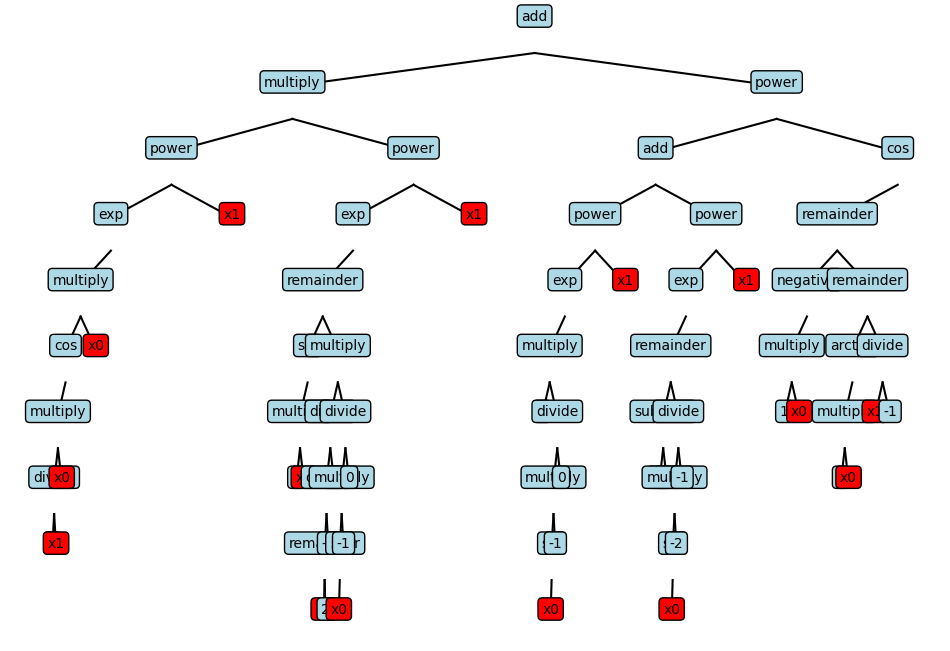

In [ ]:
#Collapse branches that can be simplified
Tree.collapse_branch(best_tree.root,0,force_collapse=True)
print(f"Collapsed formula: {best_tree.to_np_formula()}")
print("Best Tree after collapsing:")
best_tree.add_drawing()


In [4]:

formula="np.add(np.add(np.add(np.negative(np.multiply(np.multiply(np.multiply(np.add(x[5], np.cos(x[5])), 3.4533832170538705), np.add(x[5], np.add(x[5], np.cos(x[5])))), np.add(np.arcsin(np.multiply(np.divide(x[1], x[1]), np.cos(x[5]))), np.subtract(-0.389689725373902, np.subtract(np.tan(-4.984096873650183), np.cos(x[5])))))), np.multiply(np.add(np.multiply(np.multiply(np.add(x[5], 2.080092470343727), np.subtract(np.tan(-4.984096873650183), np.cos(x[5]))), np.add(np.subtract(3.4309959358615156, np.cos(x[5])), np.add(x[5], np.tan(-0.389689725373902)))), np.remainder(np.subtract(np.remainder(np.remainder(x[0], -4.016052312078411), np.remainder(x[5], 0.5710703648287252)), np.multiply(np.add(x[5], -4.984096873650183), np.multiply(-4.984096873650183, -2.36468023785525))), np.add(np.power(np.exp(x[5]), np.exp(-2.8005131036155184)), np.multiply(-4.984096873650183, 4.133039144069876)))), np.log(np.absolute(np.divide(np.divide(np.remainder(-1.5367767873214087, -2.36468023785525), np.add(x[5], -0.389689725373902)), np.cos(x[5])))))), np.add(np.multiply(np.multiply(np.multiply(-4.984096873650183, np.multiply(np.add(x[5], -0.389689725373902), 2.080092470343727)), -4.984096873650183), np.subtract(np.subtract(np.multiply(np.add(x[5], -0.389689725373902), np.add(x[5], np.add(x[5], -0.389689725373902))), x[4]), np.subtract(np.subtract(np.multiply(-4.984096873650183, -0.389689725373902), np.multiply(np.add(x[5], -2.36468023785525), 2.080092470343727)), x[4]))), np.add(np.divide(np.divide(np.remainder(np.add(x[5], np.power(2.301856003875895, -0.7510053705938358)), np.subtract(np.multiply(-4.984096873650183, 4.409196301610551), np.power(1.0169514555518528, x[2]))), np.divide(-0.389689725373902, np.subtract(np.sqrt(1.434410461293174), -4.984096873650183))), np.add(x[5], np.multiply(np.add(x[5], np.add(x[5], -1.7164765881635526)), np.add(x[5], -1.443672924613927)))), np.subtract(np.subtract(np.subtract(np.power(np.multiply(-4.8178556037767954, -4.984096873650183), np.add(x[5], -2.36468023785525)), np.multiply(np.multiply(-2.8005131036155184, x[3]), np.multiply(3.869784458158531, 4.133039144069876))), np.subtract(np.multiply(np.multiply(-4.984096873650183, -2.36468023785525), np.subtract(1.0169514555518528, -4.016052312078411)), np.multiply(np.add(x[5], -4.984096873650183), np.multiply(-4.984096873650183, -2.36468023785525)))), np.power(np.subtract(np.square(x[4]), np.subtract(-0.389689725373902, np.multiply(-3.678457221325331, -2.36468023785525))), 2.2240019148334644))))), np.multiply(-4.8178556037767954, np.multiply(np.multiply(np.add(x[5], np.multiply(np.cos(x[5]), -1.250447150656191)), np.multiply(np.remainder(np.remainder(np.sqrt(1.4450372354510659), np.add(x[5], 2.080092470343727)), np.add(x[5], np.multiply(np.cos(x[5]), -3.1415842920398673))), np.multiply(np.add(x[5], np.add(x[5], np.tan(-0.389689725373902))), np.remainder(np.add(4.133039144069876, np.absolute(0.9693457069170766)), x[5])))), 2.2240019148334644)))"

# Define the formula evaluation
def test_formula(formula, x):
    eval_formula = eval(
        f"lambda x: {formula}",
        {"np": np, "nan": np.nan, "inf": np.inf}
    )
    return eval_formula(x)


def mse_loss(x, y_true):
    squared_errors = 0
    for i in range(x.shape[0]):  # Iterate over rows (samples)
            y_pred = test_formula(formula, x[i])  # Pass one sample (row) at a time
            squared_errors += np.square(y_true[i] - y_pred)
     
    return squared_errors / x.shape[0]  # Mean of squared errors


x_tot=np.concatenate((x_train,x_test),axis=1)
y_tot=np.concatenate((y_train,y_test))
# Compute the loss
loss = mse_loss(x_tot.T, y_tot)
print(f"Loss: {loss}")


Loss: 13512.84438062582


In [50]:
# np.set_printoptions(precision=20)

# def test_formula(formula,x):
#     eval_formula = eval(f"lambda x: {formula}",{"np": np, "nan": np.nan, "inf": np.inf}) 
#     return eval_formula(x)
    
    



x_tot=np.concatenate((x_train,x_test),axis=1)
y_tot=np.concatenate((y_train,y_test))
# squared_errors = 0
# formula="np.subtract(np.multiply(np.add(np.remainder(5.093641049654384, x[1]), -11.825531918684032), x[1]), np.multiply(np.divide(np.subtract(5.093641049654384, x[2]), 1.954435340287917), np.add(np.add(-5.5958438948421225, x[1]), np.cos(x[0]))))"
# for i in range(x_tot.shape[1]):
#     y_pred = test_formula(formula,x_tot[:, i])
                 
#     squared_errors += np.square(y_tot[i] - y_pred) 

# print( squared_errors / x_tot.shape[1])
   



In [51]:
import re

def extract_constants(formula):
    """
    Takes a formula string and extracts constants, replacing them with c[i].
    
    Parameters:
    formula (str): Input formula string.
    
    Returns:
    tuple: A tuple containing:
        - Transformed formula string with constants replaced by c[i].
        - List of extracted constants.
    """
    constants = []
    
    # Regex to identify constants (floating-point or integers)
    # Matches patterns that are standalone constants, not part of variable names or functions
    constant_pattern = r'(?<![a-zA-Z_0-9\[])([-+]?\d*\.\d+|[-+]?\d+)(?![a-zA-Z_0-9\]])'
    
    def replace_constant(match):
        """
        Replace matched constant with a placeholder c[i].
        """
        constants.append(float(match.group()))
        return f'c[{len(constants) - 1}]'
    
    # Replace constants in the formula and populate the constants list
    transformed_formula = re.sub(constant_pattern, replace_constant, formula)
    
    return transformed_formula, constants


transformed_formula, initial_constants = extract_constants(best_tree.to_np_formula())
print("Transformed Formula:")
print(transformed_formula)
print("Extracted Constants:")
print(initial_constants)


Transformed Formula:
np.add(np.multiply(np.power(np.exp(np.multiply(np.cos(np.multiply(np.divide(c[0], x[1]), x[0])), x[0])), x[1]), np.power(np.exp(np.remainder(np.sin(np.multiply(c[1], x[0])), np.multiply(np.divide(np.divide(np.remainder(x[0], c[2]), c[3]), c[4]), np.divide(np.multiply(np.sin(x[0]), c[5]), c[6])))), x[1])), np.power(np.add(np.power(np.exp(np.multiply(c[7], np.divide(np.multiply(np.sin(x[0]), c[8]), c[9]))), x[1]), np.power(np.exp(np.remainder(np.subtract(x[0], x[1]), np.divide(np.multiply(np.sin(x[0]), c[10]), c[11]))), x[1])), np.cos(np.remainder(np.negative(np.multiply(c[12], x[0])), np.remainder(np.arctan(np.multiply(c[13], x[0])), np.divide(x[1], c[14]))))))
Extracted Constants:
[6.482802899893645, 1.1877872024296954, 2.301058663141874, -1.5725919920029887, -2.678140949294181, -0.8065672979000382, -0.10638834059264468, 1.3031914273616296, -0.9154561729697624, -0.41200087995525503, -2.2597688168481858, -0.8619946046528506, 0.9308912357816175, 0.5986738605992377, -

In [52]:
import numpy as np
import random


# Collapsed formula
# Optimal constants: [2.2946656427373533, 6.572177222819985, -6.452300905347215, 10.98892020920567]

# Initial constants


x_tot_t = x_tot.T

transformed_formula="np.exp(4) + (-((12 + 4) * x[0]) / (x[1] + 1)) - np.exp(np.abs(x[1])) / x[2]"

# Define the formula evaluation
def test_formula(formula, x, *c):
    eval_formula = eval(
        f"lambda x, *c: {transformed_formula}",
        {"np": np, "nan": np.nan, "inf": np.inf}
    )
    return eval_formula(x, *c)

# Define the MSE loss
def mse_loss(constants, x, y_true):
    squared_errors = 0
    for i in range(x.shape[0]):  # Iterate over rows (samples)
            y_pred = test_formula(None, x[i], *constants)  # Pass one sample (row) at a time
            squared_errors += np.square(y_true[i] - y_pred)
     
    return squared_errors / x.shape[0]  # Mean of squared errors

# Print initial loss
print("Initial loss:", mse_loss(initial_constants, x_tot_t, y_tot))

def hill_climbing_optimizer(x, y_true, initial_constants, max_iter=1000, step_size=0.1, tol=1e-6):
    current_solution = np.array(initial_constants)
    current_loss = mse_loss(current_solution, x, y_true)

    for iteration in range(max_iter):
        # Generate a random neighbor
        neighbor = current_solution + np.random.uniform(-step_size, step_size, size=current_solution.shape)
        neighbor_loss = mse_loss(neighbor, x, y_true)

        # If the neighbor is better, move to it
        if neighbor_loss < current_loss:
            current_solution = neighbor
            current_loss = neighbor_loss

        # Stop if the improvement is below tolerance
        if current_loss < tol:
            break

    return current_solution, current_loss

best_constants, best_loss = hill_climbing_optimizer(x_tot_t, y_tot, initial_constants)

# Print results
print("Optimized Constants:", best_constants)
print("Final Loss:", best_loss)

ModuleNotFoundError: No module named 'scipy'

In [7]:
from gplearn.genetic import SymbolicRegressor
est = SymbolicRegressor(population_size=500,generations=500,metric='mse',function_set=('add', 'sub', 'mul', 'div','sqrt','log','abs','neg','inv','max','min','sin','cos','tan'),verbose=1,n_jobs=-1)
est.fit(x_train.T, y_train)

    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0    10.81      4.24991e+07        5      2.26268e+07              N/A     11.31m
   1    11.95      2.35564e+07        5      2.26268e+07              N/A      3.14m
   2    14.41      3.07536e+08       22      1.96163e+07              N/A      3.48m
   3    18.65      4.62348e+07       28      1.83101e+07              N/A      3.54m
   4    26.68      3.19204e+11       23      1.20557e+07              N/A      4.09m
   5    25.89      3.47784e+10       19      1.06004e+07              N/A      4.11m
   6    25.50      2.57681e+11       24      7.01813e+06              N/A      4.29m
   7    24.93      2.46545e+12       26      6.86537e+06              N/A      3.98m
   8    23.76      1.77168e+12       26      1.39835e+06              N/A  

KeyboardInterrupt: 

TypeError: 'NoneType' object is not subscriptable